# Analysing the models

In this notebook we work under using simulations developed in the `modelling the data` notebook 

In [1]:
import pandas as pd
from datetime import timedelta, date
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy import special
import openturns as ot
from scipy.optimize import least_squares
from scipy.optimize import minimize
import warnings
from scipy.interpolate import interp1d
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

from dynamic_containment import utils

plt.rcParams['text.usetex'] = False

The goal in this notebook is to investigate how dynamic containment can be used to complement power grid when frequency in the grid changes.

We assume three different battery powers: 2 MW, 5 MW and 10 MW

First, assming white noise, following the previous notebook, we can calculate the expected rate of change of the charge for all three cases

In [2]:
service_powers = np.array([2, 5, 10])

max_charge = 4

max_charge_rate = 4.0
max_discharge_rate = 5.0

max_percent = max_charge_rate / service_powers
min_percent = max_discharge_rate / service_powers

alpha = 0.95/0.3
ccharge = 1 - 0.5 * alpha
    
delta_freq_max = (max_percent - ccharge) / alpha
delta_freq_min = (min_percent - ccharge) / alpha

Let's use the data for our variances. Note, we are using the data to cteate our simulations. In this notebook we do not cut the data, since missing data does not impact the covariance, but cutting and moving data around will likely affect the it.

In [3]:
freq_table = utils.read_and_clean()

In [4]:
dcdt = np.array([
    utils.calc_gaussian_slope(freq_table.delta_freq.std(), sp)
    for sp in service_powers
])

In [5]:
dcdt

array([-3.23914437e-07, -8.09786093e-07, -1.61958050e-06])

In [6]:
print(f"The maximum charge rates are at {100*max_percent} power")
print(f"This is when delta freq of {np.round(delta_freq_max, 2)} Hz")

The maximum charge rates are at [200.  80.  40.] power
This is when delta freq of [0.82 0.44 0.31] Hz


In [7]:
print(f"The maximum discharge rates are at {100*min_percent} power")
print(f"This is when delta freq of {-np.round(delta_freq_min, 2)} Hz")

The maximum discharge rates are at [250. 100.  50.] power
This is when delta freq of [-0.97 -0.5  -0.34] Hz


From these slopes, we can calculate how long it would take to use up a full battery (if we chose to start with one!)

In [8]:
-max_charge/(dcdt*(3600.0 * 24.0))

array([142.92754806,  57.17101922,  28.58536289])

That is, 143 days for the 2 MW battery, 57 days for the 5 MW battery and 29 days for the 10 MW battery.

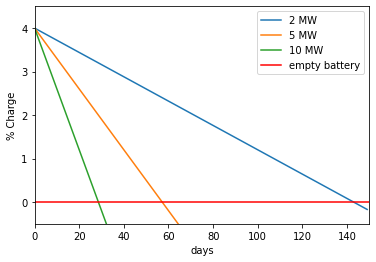

In [9]:
days = np.arange(150)
plt.plot(days, max_charge + days * (dcdt[0]*(3600.0 * 24.0)), label="2 MW")
plt.plot(days, max_charge + days * (dcdt[1]*(3600.0 * 24.0)), label="5 MW")
plt.plot(days, max_charge + days * (dcdt[2]*(3600.0 * 24.0)), label="10 MW")
plt.axhline(0, color='red', label="empty battery")
plt.ylabel("% Charge")
plt.xlabel("days")
plt.xlim([0, 150])
plt.ylim([-0.5, max_charge + 0.5])
plt.legend()


In [10]:
real_space_cov = utils.temporal_covariance(freq_table, max_sep=18001, step=50)

  0%|          | 0/361 [00:00<?, ?it/s]

In [11]:
# first makes sure I generate enough data (18000s = 5hrs)

num_blocks = np.ceil(500 * 24 * 3600 / (18000.0))

# This is the number of realisations. I have tested at higher values, but takes longer to run
nreals = 200

time_step = 1200
num_samples = [nreals, int(num_blocks)]

This takes a while, as we need to process the sims for three service powers! Note, we create independent simuations for each case

In [12]:
reals = {}

summaries = {}

num_seconds = 150 * 24 * 3600

for p in service_powers:
    
    samples = utils.simulate_grf_using_cov(real_space_cov, max_time=18000, time_step=time_step, num_samples=num_samples)
    
    new_samples = [s.flatten()[:num_seconds] for s in samples]
    
    #new_samples = utils.interp_samples(samples, max_time=num_seconds, step_samples=time_step)
    
    count = 0
    
    reals[p] = {}

    for s in tqdm(new_samples):
        
        df = pd.DataFrame()
        df["date"] = np.arange(len(s))*time_step
        df["delta_freq"] = s
        df = utils.add_charge_info(df, p, time_step)

        reals[p][count] = df
    
        count+=1
        
    summaries[p] = reals[p][0].copy()
    summaries[p]['culm_charge'] = 0.0
    summaries[p]['culm_charge_sq'] = 0.0

    for s in reals[p]:
    
        summaries[p]['culm_charge'] += reals[p][s]['culm_charge']
        summaries[p]['culm_charge_sq'] += reals[p][s]['culm_charge']**2.0

    summaries[p]['culm_charge'] = summaries[p]['culm_charge'] / len(reals[p])
    
    summaries[p]['var_charge'] = (
        summaries[p]['culm_charge_sq'] / (len(reals[p]) - 1)
        - summaries[p]['culm_charge']**2.0 * len(reals[p]) / (len(reals[p]) - 1)
    )
    
    summaries[p]['std_charge'] = np.sqrt(summaries[p]['var_charge'])
    

creating covariance
creating samples


  0%|          | 0/200 [00:00<?, ?it/s]

creating covariance
creating samples


  0%|          | 0/200 [00:00<?, ?it/s]

creating covariance
creating samples


  0%|          | 0/200 [00:00<?, ?it/s]

In [13]:
keep_charge = 10000
samp_charge = []


for s in reals[10]:
    
    samp_charge.append(float(reals[2][s].iloc[keep_charge].culm_charge))

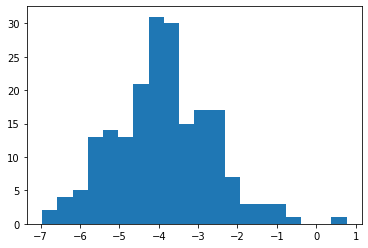

In [14]:
hist = plt.hist(samp_charge, bins=20)

For the `both` service with service power 2 MW, it is best to start with a charge of 2.57 MWh


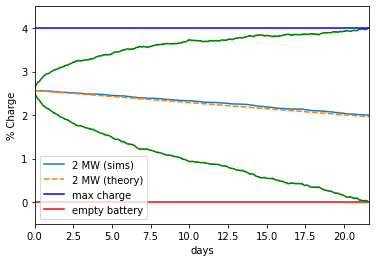

In [15]:
p = 2
nsig = 4

stds = np.array(summaries[p].std_charge)
charge = np.array(summaries[p].culm_charge)

equal_date = np.min(np.where(np.abs(nsig*stds) > 0.5 * max_charge))
charge = float(summaries[p].culm_charge.iloc[equal_date])
E0 = -0.5*max_charge - charge

days = np.arange(500)

plt.plot(summaries[p].date/(3600.0 * 24.0), max_charge + E0 + summaries[p].culm_charge, label=f"{p} MW (sims)")
plt.plot(days, max_charge + E0 + days * dcdt[np.where(service_powers==p)[0]]*(3600.0 * 24.0),  '--', label=f"{p} MW (theory)")
plt.plot(summaries[p].date/(3600.0 * 24.0), max_charge + E0 + summaries[p].culm_charge-nsig*summaries[p].std_charge, color='green')
plt.plot(summaries[p].date/(3600.0 * 24.0), max_charge + E0 + summaries[p].culm_charge+nsig*summaries[p].std_charge, color='green')
plt.axhline(max_charge, color='blue', label="max charge")
plt.axhline(0.0, color='red', label="empty battery")
plt.ylabel("% Charge")
plt.xlabel("days")
plt.ylim([-0.5, max_charge+0.5])
plt.xlim([-0.01, summaries[p].date.iloc[int(equal_date)]/(3600.0 * 24.0)])
plt.legend()

print(f"For the `both` service with service power {p} MW, it is best to start with a charge of {np.round(max_charge + E0, 2)} MWh")


In [16]:
full_discharge_dates = []

for s in reals[p]:
    
    charge = np.array(reals[p][s].culm_charge)
    
    full_discharge_dates.append(np.min(np.where(np.abs(max_charge + E0 + charge < 0))) * time_step/(24.0 * 3600))
    
print(
    f"""The average time to fully empty when starting with charge {np.round(max_charge + E0, 2)} MWh
    is {np.round(np.mean(full_discharge_dates), 2)} +/- {np.round(np.std(full_discharge_dates), 2)} days"""
)

The average time to fully empty when starting with charge 2.57 MWh
    is 94.08 +/- 38.66 days


In [17]:
print(min(full_discharge_dates))
print(max(full_discharge_dates))

31.930555555555557
287.4166666666667


(array([31., 59., 53., 34., 13.,  4.,  2.,  2.,  1.,  1.]),
 array([ 31.93055556,  57.47916667,  83.02777778, 108.57638889,
        134.125     , 159.67361111, 185.22222222, 210.77083333,
        236.31944444, 261.86805556, 287.41666667]),
 <BarContainer object of 10 artists>)

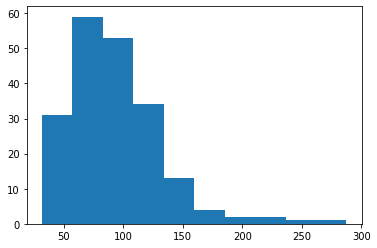

In [18]:
plt.hist(full_discharge_dates)

In [19]:
def max_date_func(E0, reals, p):
    
    date_end = []

    for s in reals[p]:

        charge = E0 + np.array(reals[p][s].culm_charge)

        min_date = np.where(charge <= 0.0)[0]
        if len(min_date):
            min_date = np.min(min_date)
        else:
            min_date = 1e10
        max_date = np.where(charge >= max_charge)[0]
        if len(max_date):
            max_date = np.min(max_date)
        else:
            max_date = 1e10
        date_end.append(np.min([min_date, max_date]))
        
    return np.array(date_end)

In [20]:
E_arr = np.linspace(0,4.0, num=401)

In [21]:
p = 2

d_mean = []
for e in E_arr:
    d_mean.append(np.mean(max_date_func(e, reals, p)))

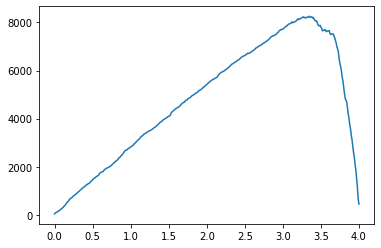

In [22]:
plt.plot(E_arr, d_mean)

In [23]:
res = np.polyfit(E_arr, d_mean, deg=8)

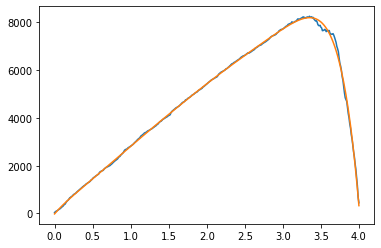

In [24]:
plt.plot(E_arr, d_mean)
plt.plot(E_arr, np.poly1d(res)(E_arr))

In [25]:
Ebest = E_arr[np.where(np.poly1d(res)(E_arr)==np.max(np.poly1d(res)(E_arr)))[0]]

In [26]:
Ebest

array([3.35])

In [27]:
dates = max_date_func(Ebest, reals, p)

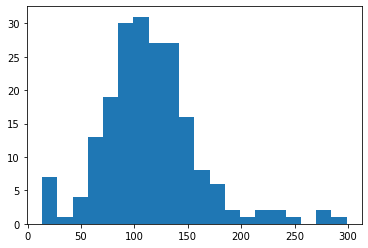

In [28]:
hist = plt.hist(dates * time_step /(3600.0 * 24.0), bins=20)

In [29]:
np.mean(dates) * time_step /(3600.0 * 24.0)

114.70201388888889